In [2]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from Bio.PDB import PDBParser, NeighborSearch
import subprocess
import prolif

In [4]:
BUST_TEST_COLUMNS = [
    # accuracy #
    "rmsd_≤_2å",
    # chemical validity and consistency #
    "mol_pred_loaded",
    "mol_true_loaded",
    "mol_cond_loaded",
    "sanitization",
    "molecular_formula",
    "molecular_bonds",
    "tetrahedral_chirality",
    "double_bond_stereochemistry",
    # intramolecular validity #
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "double_bond_flatness",
    "internal_energy",
    # intermolecular validity #
    "minimum_distance_to_protein",
    "minimum_distance_to_organic_cofactors",
    "minimum_distance_to_inorganic_cofactors",
    "volume_overlap_with_protein",
    "volume_overlap_with_organic_cofactors",
    "volume_overlap_with_inorganic_cofactors",
]

#  Load Data and Classify Success/Failure


In [ ]:
df = pd.read_csv(f"posebusters_results_filtered.csv")

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_10757/3510272812.py:1: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"posebusters_results_filtered.csv")


## get the protien and ligand names 


In [ ]:
BASE_DIR = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"

def get_ligand_smiles(protein_name):
    sdf_file = os.path.join(BASE_DIR, protein_name, f"{protein_name}_ligand.sdf")
    suppl = Chem.SDMolSupplier(sdf_file)
    if suppl and len(suppl) > 0 and suppl[0] is not None:
        return Chem.MolToSmiles(suppl[0])
    return None

def get_protein_pdb_path(protein_name):
    return os.path.join(BASE_DIR, protein_name, f"{protein_name}_protein.pdb")

def get_protein_pocket_cropped_path(protein_name):
    return os.path.join(BASE_DIR, protein_name, f"{protein_name}_pocket_cropped.pdb")

df['ligand_smiles'] = df['protein'].apply(get_ligand_smiles)
df['protein_pdb'] = df['protein'].apply(get_protein_pdb_path)


In [17]:
# Define success: RMSD < 2 Å (adjust the column name if needed)
# For example, if the column is named "rmsd":
df['success'] = df['rmsd'] < 2

# Split into two groups
success_df = df[df['success']].copy()
failure_df = df[~df['success']].copy()

print(f"Total cases: {len(df)} | Successful: {len(success_df)} | Failed: {len(failure_df)}")

Total cases: 9245 | Successful: 4012 | Failed: 5233


In [6]:
success_df['protein']

3       7ZDY_6MJ
5       8F8E_XJI
7       8F8E_XJI
10      7U3J_L6U
11      7U3J_L6U
          ...   
9240    7D6O_MTE
9241    7D6O_MTE
9242    7D6O_MTE
9243    7D6O_MTE
9244    7D6O_MTE
Name: protein, Length: 4012, dtype: object

# Feature Analysis of Failed Cases

In [28]:
def compute_ligand_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Could not parse the SMILES string
    return {
        "HeavyAtomCount": Descriptors.HeavyAtomCount(mol),
        "MolWt": Descriptors.MolWt(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
        "LogP": Descriptors.MolLogP(mol),
        "FormalCharge": Chem.GetFormalCharge(mol),
        "TPSA": Descriptors.TPSA(mol)
    }

df['ligand_desc'] = df['ligand_smiles'].apply(compute_ligand_descriptors)
# Expand the descriptor dictionaries into separate columns (for easier analysis)
df_descriptors = pd.json_normalize(df['ligand_desc'])
# Merge back into the dataframes
df = pd.concat([df.reset_index(drop=True), df_descriptors], axis=1)

In [29]:

# Choose the appropriate column that holds the ligand representation.
# For example, if "inchi_docked" holds a SMILES-like string:
success_df['ligand_desc'] = success_df['ligand_smiles'].apply(compute_ligand_descriptors)
failure_df['ligand_desc'] = failure_df['ligand_smiles'].apply(compute_ligand_descriptors)

# Expand the descriptor dictionaries into separate columns (for easier analysis)
ligand_desc_success = pd.json_normalize(success_df['ligand_desc'])
ligand_desc_failure = pd.json_normalize(failure_df['ligand_desc'])

# Merge back into the dataframes
success_df = pd.concat([success_df.reset_index(drop=True), ligand_desc_success], axis=1)
failure_df = pd.concat([failure_df.reset_index(drop=True), ligand_desc_failure], axis=1)

# Check summary statistics
print("Successful cases ligand descriptors:")
print(success_df[['HeavyAtomCount', 'MolWt', 'NumRotatableBonds', 'LogP', 'FormalCharge', 'TPSA']].describe())

print("Failed cases ligand descriptors:")
print(failure_df[['HeavyAtomCount', 'MolWt', 'NumRotatableBonds', 'LogP', 'FormalCharge', 'TPSA']].describe())


Successful cases ligand descriptors:
       HeavyAtomCount        MolWt  NumRotatableBonds         LogP  \
count     4012.000000  4012.000000        4012.000000  4012.000000   
mean        24.429462   357.480287           5.150798     1.095237   
std         10.182344   149.001332           3.306641     2.906267   
min          6.000000   100.117000           0.000000    -4.847100   
25%         17.000000   242.403000           3.000000    -1.575200   
50%         25.000000   364.485000           5.000000     0.972800   
75%         32.000000   456.539000           7.000000     3.514200   
max         57.000000   871.649000          20.000000     8.976800   

       FormalCharge         TPSA  
count   4012.000000  4012.000000  
mean       0.021436   122.350573  
std        0.233216    74.363241  
min       -2.000000     0.000000  
25%        0.000000    64.962500  
50%        0.000000   104.060000  
75%        0.000000   161.230000  
max        2.000000   383.860000  
Failed cases liga

In [12]:
success_df[success_df['method']=='diffdock_pocket_only'].shape

(638, 143)

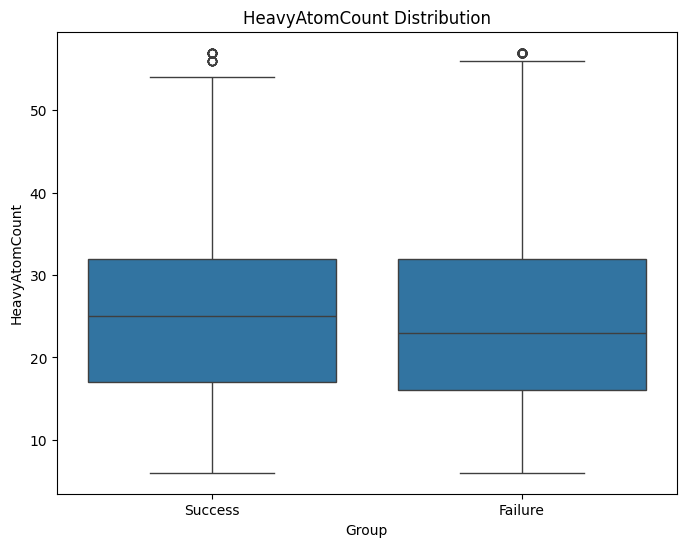

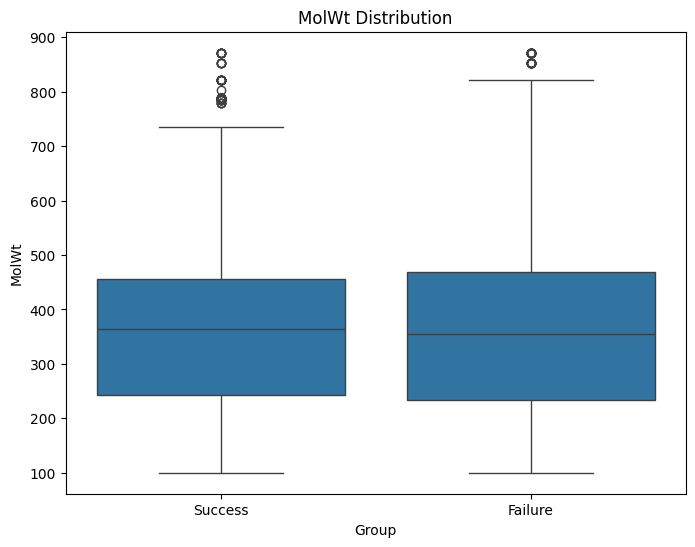

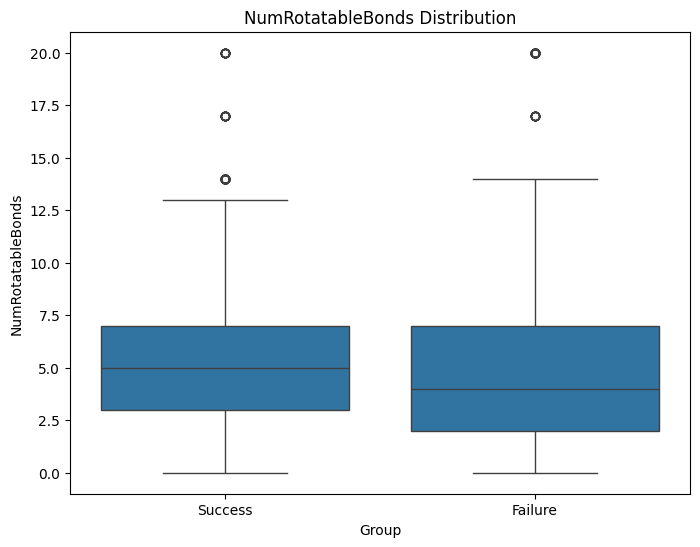

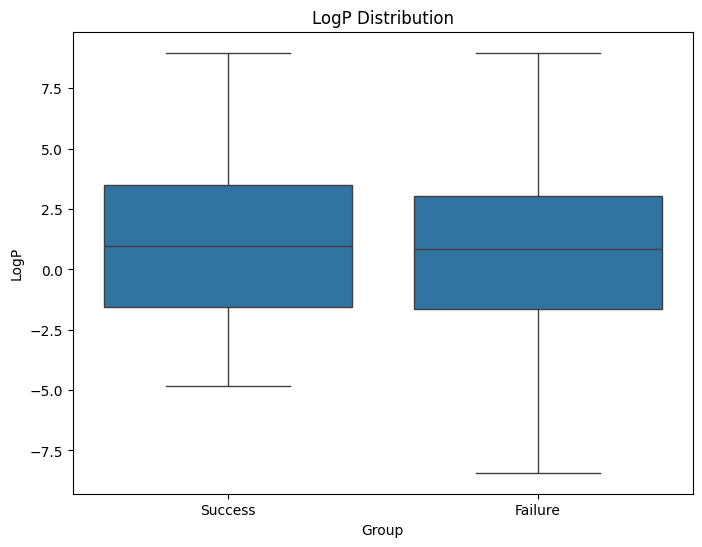

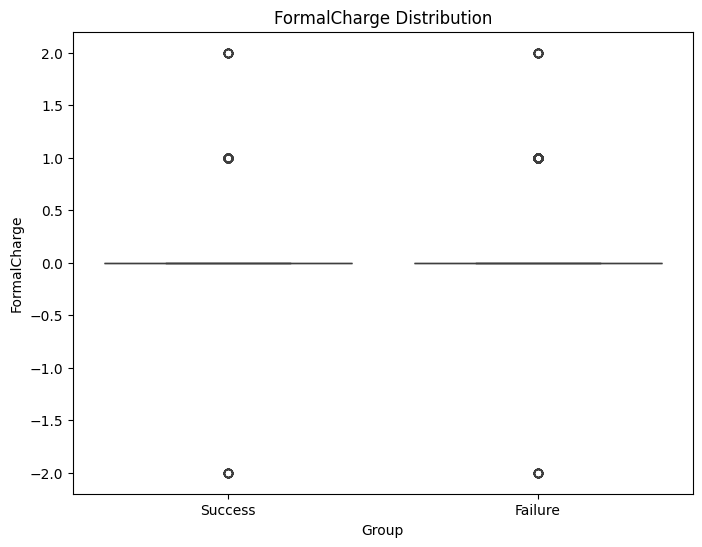

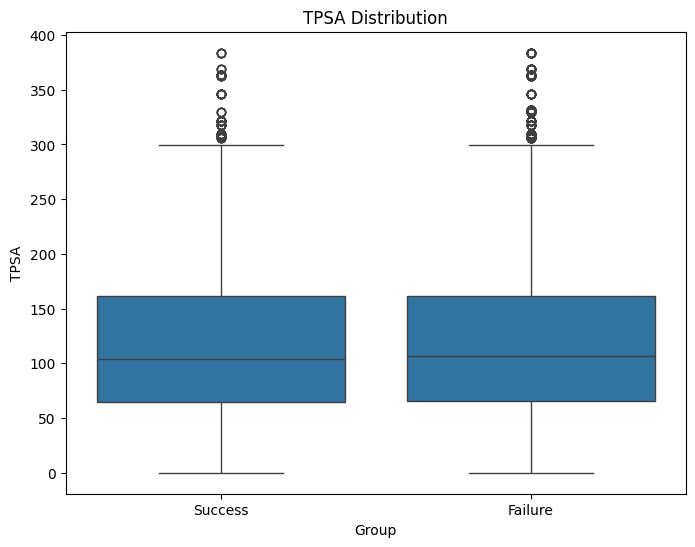

In [21]:
# Compare the distribution of, for example, molecular weight between the two groups.
for feature in ['HeavyAtomCount', 'MolWt', 'NumRotatableBonds', 'LogP', 'FormalCharge', 'TPSA']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=pd.concat([
        success_df.assign(Group="Success"),
        failure_df.assign(Group="Failure")
    ]), x="Group", y=f"{feature}")
    plt.title(f"{feature} Distribution")
    plt.ylabel(f"{feature}")
    plt.show()


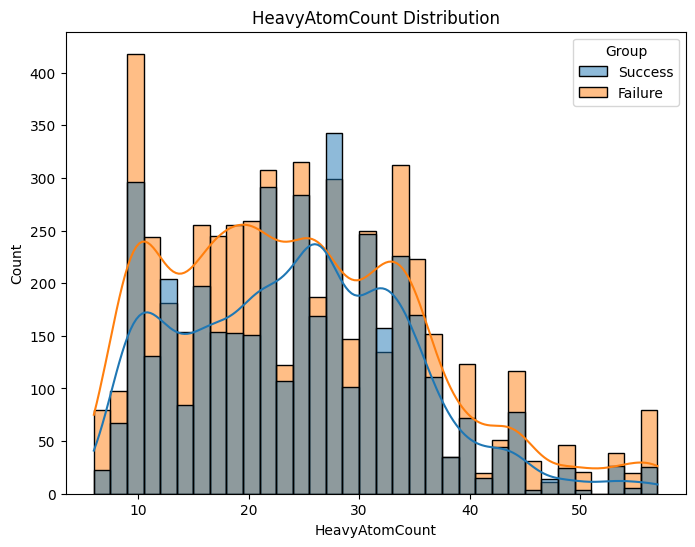

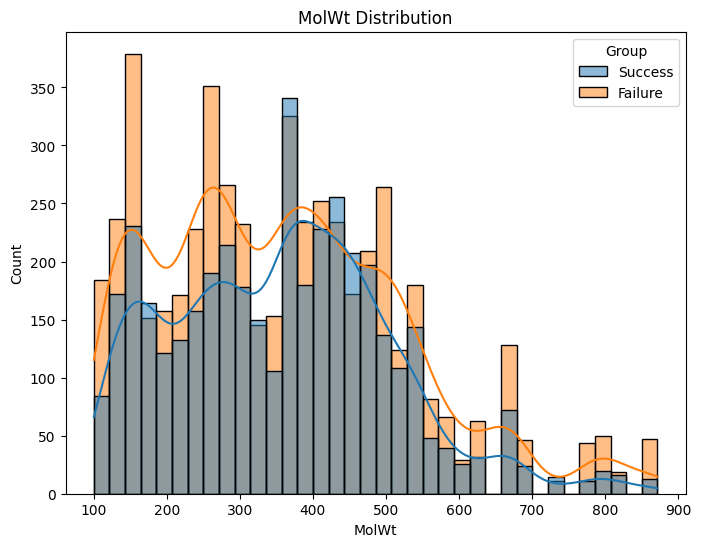

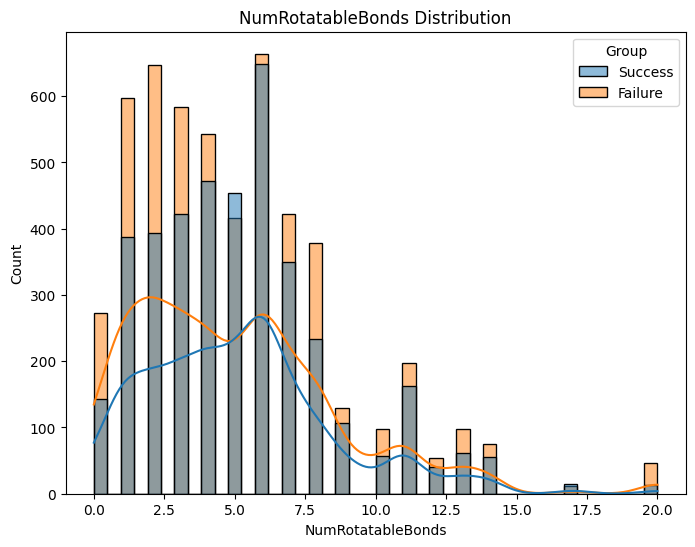

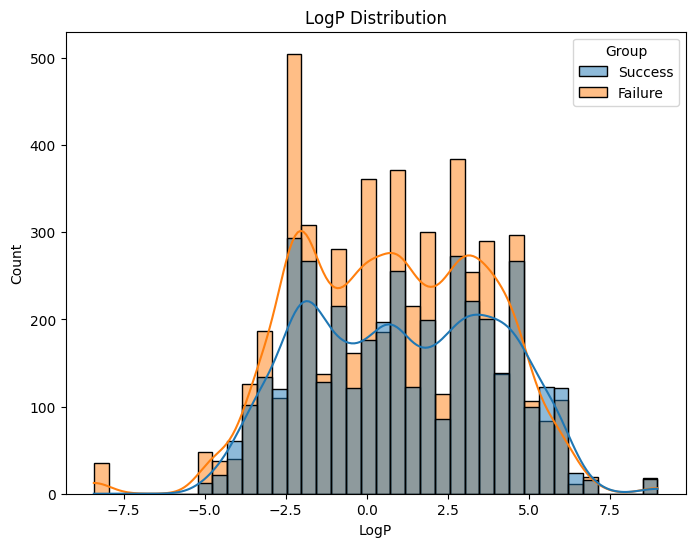

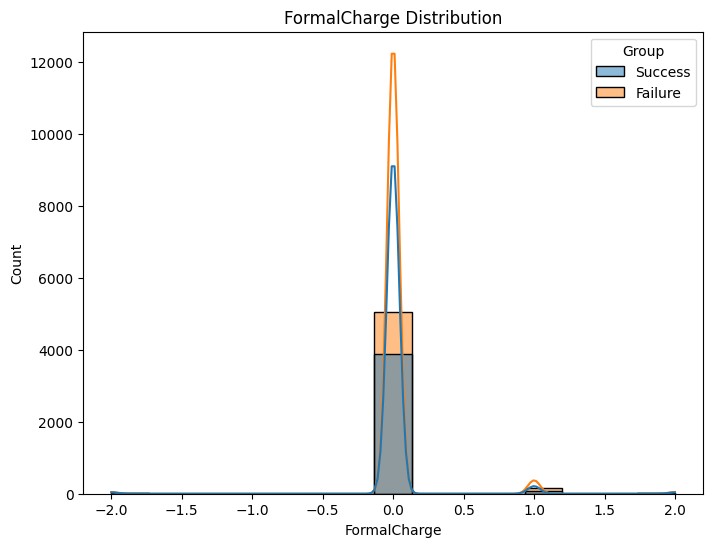

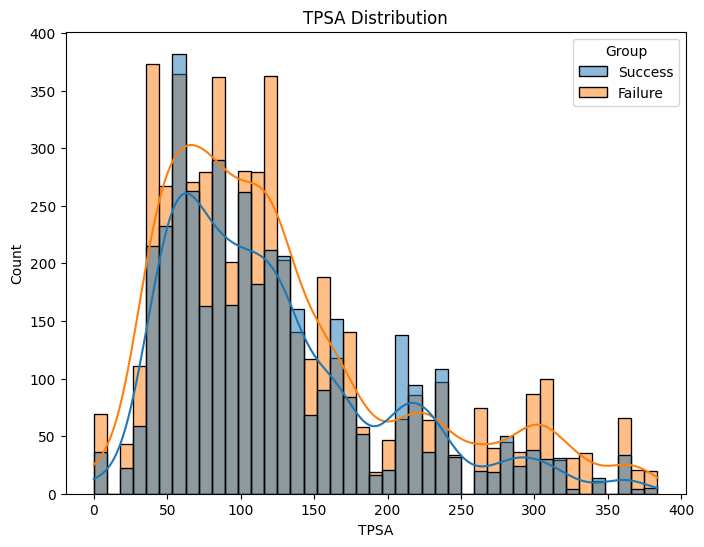

In [19]:
for features in ['HeavyAtomCount', 'MolWt', 'NumRotatableBonds', 'LogP', 'FormalCharge', 'TPSA']:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=pd.concat([
        success_df.assign(Group="Success"),
        failure_df.assign(Group="Failure")
    ]), x=features, hue="Group", kde=True)
    plt.title(f"{features} Distribution")
    plt.show()



In [30]:
# group1_data = merged[merged['group'] == 'ml_succeeds_physics_fails']
# group_data = merged[merged['group'] == 'physics_succeeds_ml_fails']
group1_data = df[df['method'] == 'diffdock_pocket_only']
group2_data = df[df['method'] == 'icm']

In [31]:
group1_data = group1_data[group1_data['rank']==1]
group2_data = group2_data[group2_data['rank']==1]
group1_data.shape, group2_data.shape

((257, 143), (279, 143))

In [32]:
from scipy.stats import mannwhitneyu  # add import if not already imported

for feature in ['HeavyAtomCount', 'MolWt', 'NumRotatableBonds', 'LogP', 'FormalCharge', 'TPSA']:
    # Statistical test (Mann-Whitney U)
    _, p = mannwhitneyu(df[feature].dropna(), group2_data[feature].dropna())
    print(f'{feature} difference p-value: {p:.4f}')

HeavyAtomCount difference p-value: 0.7049
MolWt difference p-value: 0.6935
NumRotatableBonds difference p-value: 0.6613
LogP difference p-value: 0.8640
FormalCharge difference p-value: 0.9518
TPSA difference p-value: 0.6925


In [33]:
atom_features = ['HeavyAtomCount', 'MolWt', 'NumRotatableBonds', 'LogP', 'FormalCharge', 'TPSA']

# B. Protein Properties Analysis


### 1. Compute pocket volume for all proteins:



In [16]:
import pyvol
print(dir(pyvol))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [ ]:
from pyvol import pv

def compute_pocket_volume(pdb_file):
    """Compute pocket volume from a PDB file."""
    # Replace with your protein PDB path (from df['protein'] column)
    pocket = pv.Pocket(pdb_file)
    return pocket.volume()

# Assuming df['protein'] contains paths to PDB files
df['pocket_volume'] = df['protein'].apply(compute_pocket_volume)

### 2. Binding Site Flexibility (B-Factors)
Extract B-factors from PDB files (requires Biopython): B-factor (also named temperature factor or Debye-Waller factor) is a measure of the displacement of atoms in a crystal structure. It is a measure of the uncertainty in the position of an atom in a crystal structure. High B-factors indicate high flexibility of the atoms, while low B-factors indicate low flexibility. B-factors are often used to identify flexible regions in proteins, such as binding sites.

In [8]:
from Bio.PDB import PDBParser

def compute_avg_bfactor(pdb_file, chain='A'):
    """Compute average B-factor of binding site residues."""
    parser = PDBParser()
    structure = parser.get_structure('protein', pdb_file)
    b_factors = []
    for residue in structure[0][chain]:
        for atom in residue:
            b_factors.append(atom.get_bfactor())
    return np.mean(b_factors)


def compute_average_bfactor(pdb_file):
    # Create a PDBParser object
    parser = PDBParser(QUIET=True)
    
    # Parse the structure from the PDB file
    structure = parser.get_structure("protein", pdb_file)
    
    # List to hold all B-factors
    b_factors = []
    
    # Iterate over all atoms in the structure
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    b_factors.append(atom.get_bfactor())
                    
    # Compute average B-factor
    average_bfactor = np.mean(b_factors) if b_factors else None
    return average_bfactor

df['avg_bfactor'] = df['protein_pdb'].apply(compute_average_bfactor)

In [14]:
df.to_csv("posebusters_results_filtered_with_descriptors.csv", index=False)

### 3. Compare Protein Features


In [ ]:
# Example: Pocket volume vs. failure group
sns.boxplot(x='group', y='pocket_volume', data=pd.concat([group1_data, group2_data]))
plt.title('Pocket Volume in Failure Groups')
plt.show()

# C. Protein-Ligand Interactions



### 1. Compute Interaction Fingerprints

ProLIF can detect multiple types of non-covalent interactions, including:
* Hydrogen bonds
* π-π stacking
* Hydrophobic interactions
* Salt bridges
* Cation-π interactions


In [59]:
# example usage of prolif
import MDAnalysis as mda
import prolif as plf
from prolif.molecule import Molecule
from prolif.plotting.complex3d import Complex3D

#### Specific Analysis

In [8]:
# Load the static protein structure
complex_name = "7PK0_BYC"
protein_pdb = os.path.join(BASE_DIR, f"{complex_name}", f'{complex_name}_protein.pdb')
docked_ligand_path = os.path.join(BASE_DIR, f"{complex_name}", f'{complex_name}_ligand.sdf')

rdkit_prot = Chem.MolFromPDBFile(protein_pdb, removeHs=False)
protein = plf.Molecule(rdkit_prot)

# u = mda.Universe(protein_pdb)
# protein = plf.Molecule.from_mda(u)  # Convert to ProLIF molecule


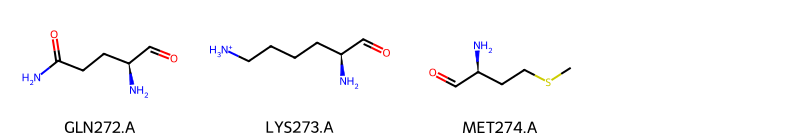

In [9]:
plf.display_residues(protein, slice(260, 263))

In [10]:
pose_iterable = plf.sdf_supplier(docked_ligand_path)

In [11]:
# Load the ligand from an SDF file
docked_ligand_path = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7PK0_BYC/rank1.sdf"
supplier = Chem.SDMolSupplier(docked_ligand_path)
ligands = [Molecule.from_rdkit(mol) for mol in supplier if mol is not None]
ligand = ligands[0]  # Take the first ligand (if multiple poses exist)

In [13]:
# Initialize a fingerprint calculator
fp = plf.Fingerprint(plf.Fingerprint.list_available())

# Compute interactions
fp.run_from_iterable(pose_iterable, protein)


  0%|          | 0/1 [00:00<?, ?it/s]

<prolif.fingerprint.Fingerprint: 15 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'XBAcceptor', 'XBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'FaceToFace', 'EdgeToFace', 'PiStacking', 'MetalDonor', 'MetalAcceptor', 'VdWContact'] at 0x33811da00>

In [14]:
ifp = fp.generate(protein, ligand)

In [15]:
# refernce
ifp

{(ResidueId(LYS, 160, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False]), (ResidueId(PHE, 183, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(TRP, 184, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(LEU, 185, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(GLY, 231, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(THR, 232, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, Fals

In [16]:
# icm
ifp

{(ResidueId(LYS, 160, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False]), (ResidueId(PHE, 183, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(TRP, 184, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(LEU, 185, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(GLY, 231, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True]), (ResidueId(THR, 232, A), ResidueId(UNL, 1, None)): array([False, False, False, False, False, False, False, False, False,
       False, Fals

In [ ]:
comp3D = Complex3D(ifp, ligand, protein)

view = comp3D.display()
view

In [ ]:
# Convert the dictionary to a more readable format
interaction_list = []
for (protein_residue, ligand_residue), interaction_array in ifp.items():
    protein_residue_name = f"{protein_residue.resname}{protein_residue.resid}({protein_residue.chain})"
    ligand_residue_name = f"{ligand_residue.resname}{ligand_residue.resid}"
    
    interaction_types = plf.Fingerprint.list_available()  # Assuming this matches the array order
    interactions = dict(zip(interaction_types, interaction_array))
    
    # Append the results to the list
    interaction_list.append({
        'Protein Residue': protein_residue_name,
        'Ligand Residue': ligand_residue_name,
        'Interactions': interactions
    })

# Create a Pandas DataFrame
interaction_df = pd.DataFrame(interaction_list)

# Show the DataFrame
print(interaction_df)

In [59]:
fp.to_pickle("fingerprint.pkl")
fp = plf.Fingerprint.from_pickle("fingerprint.pkl")

In [56]:
plf.Fingerprint.list_available()

['Anionic',
 'CationPi',
 'Cationic',
 'EdgeToFace',
 'FaceToFace',
 'HBAcceptor',
 'HBDonor',
 'Hydrophobic',
 'MetalAcceptor',
 'MetalDonor',
 'PiCation',
 'PiStacking',
 'VdWContact',
 'XBAcceptor',
 'XBDonor']

In [61]:
prolif_df = fp.to_dataframe(index_col="Pose")
# show only the 5 first poses
print(prolif_df)
# percentage of poses where each interaction is present
(prolif_df.mean().sort_values(ascending=False).to_frame(name="%").T * 100)

ligand            UNL1           
protein       DMS401.A   ZRY404.A
interaction VdWContact VdWContact
Pose                             
0                 True       True


ligand            UNL1           
protein       DMS401.A   ZRY404.A
interaction VdWContact VdWContact
%                100.0      100.0

In [ ]:
# load the reference
ref = mda.Universe(plf.datafiles.datapath / "vina" / "lig.pdb")
ref_mol = plf.Molecule.from_mda(ref)

# generate IFP for the reference
fp_ref = plf.Fingerprint(fp.interactions)
fp_ref.run_from_iterable([ref_mol], protein_mol)
df_ref = fp_ref.to_dataframe(index_col="Pose")

# set the "pose index" to -1
df_ref.rename(index={0: -1}, inplace=True)
# set the ligand name to be the same as poses
df_ref.rename(columns={str(ref_mol[0].resid): df.columns.levels[0][0]}, inplace=True)
df_ref

In [ ]:
def compute_interactions(protein_pdb, ligand_sdf):
    """Compute interaction fingerprints between protein and ligand."""
    lig = Chem.MolFromMolFile(ligand_sdf)
    prot = Chem.MolFromPDBFile(protein_pdb)
    pf = ProLIF()
    pf.run(prot, lig)
    return pf.to_dataframe()

# Apply to your data (assuming paths to PDB/SDF files)
df['interactions'] = df.apply(
    lambda row: compute_interactions(row['protein_pdb'], row['ligand_smiles']), axis=1
)

# Qualitative Analysis of Failed Cases

analysi the complements of the failed cases and try to find the common features that may lead to the failure of the docking process
1. Ligand features
2. Protein features
3. Posebusters filters

In [5]:
df = pd.read_csv(f"posebusters_results_filtered_with_descriptors.csv")

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_32598/1983762611.py:1: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"posebusters_results_filtered_with_descriptors.csv")


In [9]:
# For each protein, count how many methods succeeded
success_counts = (
    df[df["success"] == True]
    .groupby(["protein","method"])["success"]
    .first()  # or .any(), if multiple rows
    .unstack(fill_value=False)
)
success_counts.head()

method,chai-1,diffdock,diffdock_pocket_only,gnina,icm,surfdock,vina
protein,,,,,,,
5SAK_ZRY,True,True,True,True,True,True,True
5SB2_1K2,True,True,True,True,True,True,True
5SD5_HWI,True,True,True,True,True,True,False
6M2B_EZO,True,True,True,True,True,False,True
6M73_FNR,True,True,True,True,True,True,True


In [7]:
def mannwhitneyu_test(df1, df2, feature):
    _, p = mannwhitneyu(df1[feature].dropna(), df2[feature].dropna())
    print(f'{feature} difference p-value: {p:.4f}')

def posebuster_test(df1, df2, features):
    for feature in features:
        print(f"Feature: {feature}")
        mannwhitneyu_test(df1, df2, feature)

def get_method_failure_proteins(df, method):
    success_counts = (
    df[df["success"] == True]
    .groupby(["protein","method"])["success"]
    .first()  # or .any(), if multiple rows
    .unstack(fill_value=False)
    )
    return success_counts[success_counts[method] == False].index
   

def get_method_success_proteins(df, method):
    success_counts = (
        df[df["success"] == True]
        .groupby(["protein","method"])["success"]
        .first()  # or .any(), if multiple rows
        .unstack(fill_value=False)
    )
    return success_counts[success_counts[method] == True].index

def get_complementary_proteins(df, method1, method2):
    failure_proteins = get_method_failure_proteins(df, method1)
    success_proteins = get_method_success_proteins(df, method2)
    complementary_proteins = set(failure_proteins).intersection(success_proteins)
    

    print(f'Complementary proteins between {method1} and {method2}: {complementary_proteins}')
    

    print(f'Number of complementary proteins: {len(complementary_proteins)}')
    
    return complementary_proteins

In [11]:
# cases where diffdock_poceket_only success and icm failed
diffdock_icm_comp = ['6TW7_NZB', '7QE4_NGA', '8B8H_OJQ', '8D19_GSH']
# the contracy cases
icm_diffdock_comp = ['6T88_MWQ', '6XBO_5MC', '6XM9_V55', '6YJA_2BA', '6YMS_OZH', '6YRV_PJ8', '6YYO_Q1K', '6Z0R_Q4H', '6Z2C_Q5E', '6Z4N_Q7B', '6ZC3_JOR', '6ZK5_IMH', '6ZPB_3D1', '7A9E_R4W', '7AN5_RDH', '7BKA_4JC', '7BMI_U4B', '7BNH_BEZ', '7C0U_FGO', '7C3U_AZG', '7C8Q_DSG', '7CD9_FVR', '7CIJ_G0C', '7CL8_TES', '7CNS_PMV', '7CUO_PHB', '7D5C_GV6', '7D6O_MTE', '7DQL_4CL', '7EBG_J0L', '7ECR_SIN', '7FB7_8NF', '7JG0_GAR', '7JMV_4NC', '7KB1_WBJ', '7KQU_YOF', '7KRU_ATP', '7L00_XCJ', '7L5F_XNG', '7LCU_XTA', '7LMO_NYO', '7LOE_Y84', '7LZD_YHY', '7M3H_YPV', '7M6K_YRJ', '7MFP_Z7P', '7MGT_ZD4', '7MOI_HPS', '7MSR_DCA', '7MWN_WI5', '7MWU_ZPM', '7N4W_P4V', '7N6F_0I1', '7N7B_T3F', '7N7H_CTP', '7NF0_BYN', '7NF3_4LU', '7NLV_UJE', '7NPL_UKZ', '7NUT_GLP', '7NXO_UU8', '7O0N_CDP', '7O1T_5X8', '7OFF_VCB', '7OLI_8HG', '7OPG_06N', '7OZ9_NGK', '7OZC_G6S', '7P1F_KFN', '7P5T_5YG', '7PJQ_OWH', '7PRI_7TI', '7Q2B_M6H', '7QTA_URI', '7R6J_2I7', '7RH3_59O', '7RWS_4UR', '7SDD_4IP', '7SFO_98L', '7SZA_DUI', '7TB0_UD1', '7TBU_S3P', '7TE8_P0T', '7TH4_FFO', '7TOM_5AD', '7TS6_KMI', '7TSF_H4B', '7TUO_KL9', '7U3J_L6U', '7UAW_MF6', '7ULC_56B', '7UXS_OJC', '7UY4_SMI', '7V43_C4O', '7VBU_6I4', '7VQ9_ISY', '7VYJ_CA0', '7W06_ITN', '7WKL_CAQ', '7WUY_76N', '7X5N_5M5', '7XPO_UPG', '7XQZ_FPF', '7XRL_FWK', '7YZU_DO7', '7Z2O_IAJ', '7ZF0_DHR', '8A2D_KXY', '8AEM_LVF', '8AIE_M7L', '8AP0_PRP', '8AQL_PLG', '8AUH_L9I', '8BTI_RFO', '8C3N_ADP', '8C5M_MTA', '8D39_QDB', '8DHG_T78', '8DKO_TFB', '8EXL_799', '8EYE_X4I', '8F8E_XJI', '8FO5_Y4U', '8GFD_ZHR', '8HO0_3ZI']
# Select rows from the success dataframe where the 'protein' column is in diffdock_icm_comp
# filtered_success = success_df[success_df['protein'].isin(diffdock_icm_comp) & success_df['method'].isin(["diffdock_pocket_only", "icm"])]

In [12]:
diffdock_icm_comp_df = df[(df['protein'].isin(diffdock_icm_comp)) & (df['method'].isin(["diffdock_pocket_only", "icm"]))]
icm_diffdock_comp_df = df[(df['protein'].isin(icm_diffdock_comp)) & (df['method'].isin(["diffdock_pocket_only", "icm"]))]

In [13]:
group1_data = diffdock_icm_comp_df[diffdock_icm_comp_df['method'] == 'diffdock_pocket_only']
group2_data = diffdock_icm_comp_df[diffdock_icm_comp_df['method'] == 'icm']


### Posebusters Filters

In [20]:
def compare_boolean_columns(group1_data, group2_data, columns, figsize=(12,6), bar_width=0.35):
    """
    Computes and plots the percentage of True values for given boolean columns
    in two groups. It prints the percentages and the differences.

    Parameters:
        group1_data (DataFrame): DataFrame for group 1.
        group2_data (DataFrame): DataFrame for group 2.
        columns (list): List of boolean column names to analyze.
        figsize (tuple): Figure size for the plot.
        bar_width (float): Width of the bars in the plot.
    
    Returns:
        group1_stats (Series): Percentage of True for each column in group1.
        group2_stats (Series): Percentage of True for each column in group2.
        diff_stats (Series): Difference (group1 - group2) in percentage points.
    """
    # Compute the percentage of True for each specified boolean column in both groups
    group1_stats = group1_data[columns].mean() * 100
    group2_stats = group2_data[columns].mean() * 100
    diff_stats = group1_stats - group2_stats

    # Print the statistics
    print("Group 1 percentage of True:")
    print(group1_stats)
    print("\nGroup 2 percentage of True:")
    print(group2_stats)
    print("\nDifference (Group1 - Group2) in percentage points:")
    print(diff_stats)

    # Plot the results for visual comparison
    plt.figure(figsize=figsize)
    x = np.arange(len(columns))
    plt.bar(x - bar_width/2, group1_stats, bar_width, label='Group1')
    plt.bar(x + bar_width/2, group2_stats, bar_width, label='Group2')
    plt.xticks(x, columns, rotation=90)
    plt.ylabel('% True')
    plt.title('Comparison of Boolean Columns Between Groups')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return group1_stats, group2_stats, diff_stats

#### ICM and Diffdock

Group 1 (diffdock_pocket_only) percentage of True:
rmsd_≤_2å                                   90.0
mol_pred_loaded                            100.0
mol_true_loaded                            100.0
mol_cond_loaded                            100.0
sanitization                               100.0
molecular_formula                          100.0
molecular_bonds                            100.0
tetrahedral_chirality                      100.0
double_bond_stereochemistry                100.0
bond_lengths                               100.0
bond_angles                                100.0
internal_steric_clash                      100.0
aromatic_ring_flatness                     100.0
double_bond_flatness                       100.0
internal_energy                            100.0
minimum_distance_to_protein                 30.0
minimum_distance_to_organic_cofactors      100.0
minimum_distance_to_inorganic_cofactors    100.0
volume_overlap_with_protein                 90.0
volume_overlap_wit

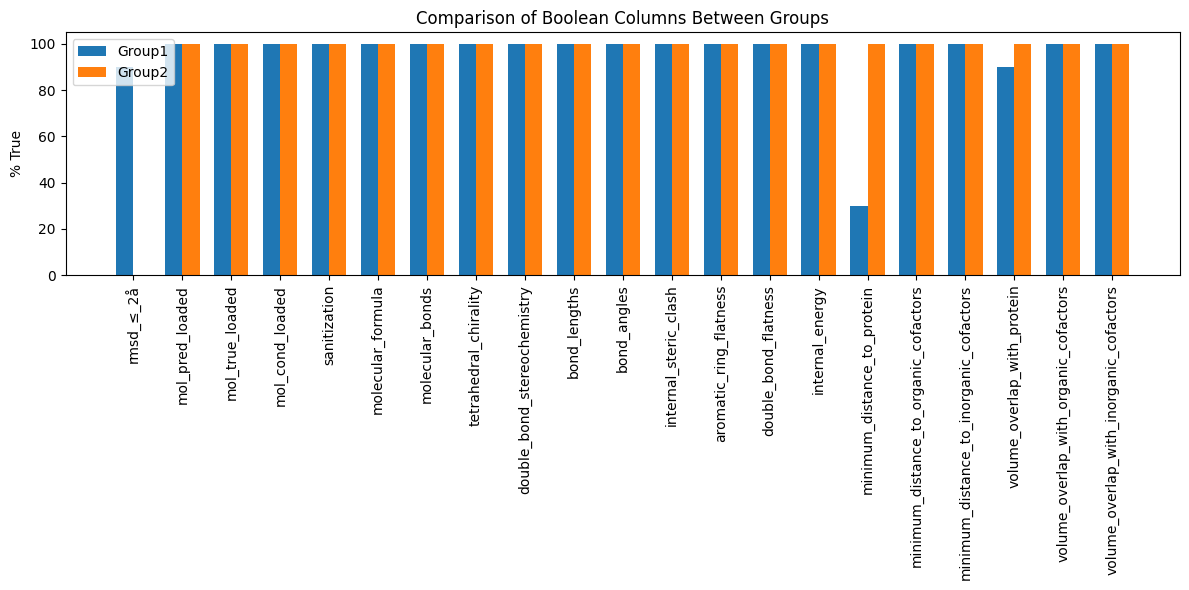

(rmsd_≤_2å                                   90.0
 mol_pred_loaded                            100.0
 mol_true_loaded                            100.0
 mol_cond_loaded                            100.0
 sanitization                               100.0
 molecular_formula                          100.0
 molecular_bonds                            100.0
 tetrahedral_chirality                      100.0
 double_bond_stereochemistry                100.0
 bond_lengths                               100.0
 bond_angles                                100.0
 internal_steric_clash                      100.0
 aromatic_ring_flatness                     100.0
 double_bond_flatness                       100.0
 internal_energy                            100.0
 minimum_distance_to_protein                 30.0
 minimum_distance_to_organic_cofactors      100.0
 minimum_distance_to_inorganic_cofactors    100.0
 volume_overlap_with_protein                 90.0
 volume_overlap_with_organic_cofactors      100.0


In [49]:
compare_boolean_columns(group1_data, group2_data, BUST_TEST_COLUMNS)

Group 1 (diffdock_pocket_only) percentage of True:
rmsd_≤_2å                                    0.000000
mol_pred_loaded                            100.000000
mol_true_loaded                            100.000000
mol_cond_loaded                            100.000000
sanitization                               100.000000
molecular_formula                          100.000000
molecular_bonds                            100.000000
tetrahedral_chirality                      100.000000
double_bond_stereochemistry                 99.056604
bond_lengths                               100.000000
bond_angles                                100.000000
internal_steric_clash                       97.547170
aromatic_ring_flatness                     100.000000
double_bond_flatness                        98.867925
internal_energy                             96.603774
minimum_distance_to_protein                 15.471698
minimum_distance_to_organic_cofactors       74.528302
minimum_distance_to_inorganic_c

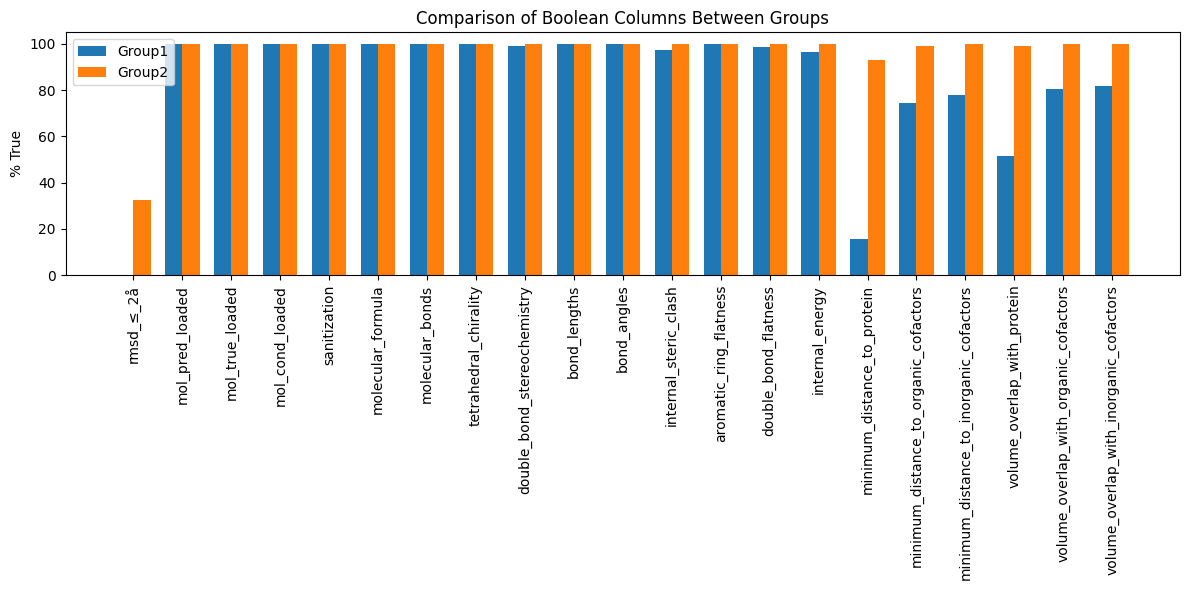

(rmsd_≤_2å                                    0.000000
 mol_pred_loaded                            100.000000
 mol_true_loaded                            100.000000
 mol_cond_loaded                            100.000000
 sanitization                               100.000000
 molecular_formula                          100.000000
 molecular_bonds                            100.000000
 tetrahedral_chirality                      100.000000
 double_bond_stereochemistry                 99.056604
 bond_lengths                               100.000000
 bond_angles                                100.000000
 internal_steric_clash                       97.547170
 aromatic_ring_flatness                     100.000000
 double_bond_flatness                        98.867925
 internal_energy                             96.603774
 minimum_distance_to_protein                 15.471698
 minimum_distance_to_organic_cofactors       74.528302
 minimum_distance_to_inorganic_cofactors     77.735849
 volume_ov

In [50]:
group1_data = icm_diffdock_comp_df[icm_diffdock_comp_df['method'] == 'diffdock_pocket_only']
group2_data = icm_diffdock_comp_df[icm_diffdock_comp_df['method'] == 'icm']

compare_boolean_columns(group1_data, group2_data, BUST_TEST_COLUMNS)


#### surfdock and ICM

In [ ]:
surfdock_complement_icm = get_complementary_proteins(df, "surfdock", "icm")
icm_complement_surfdock = get_complementary_proteins(df, "icm", "surfdock")

Complementary proteins between surfdock and icm: {'7OZC_G6S', '7F8T_FAD', '7XFA_D9J', '6XM9_V55', '6Z0R_Q4H', '7WUY_76N', '6YR2_T1C', '7MMH_ZJY', '6M2B_EZO', '7LOE_Y84', '7UXS_OJC', '7MWU_ZPM', '6YJA_2BA', '6TW5_9M2', '7MGY_ZD1', '7OLI_8HG', '6ZPB_3D1', '7TUO_KL9', '7F5D_EUO', '6T88_MWQ', '7RWS_4UR', '7YZU_DO7'}
Number of complementary proteins: 22
Complementary proteins between icm and surfdock: {'8B8H_OJQ', '8D19_GSH', '7QE4_NGA', '8HFN_XGC', '7R3D_APR', '7WUX_6OI', '7RNI_60I', '7XBV_APC', '7PT3_3KK', '6ZAE_ACV'}
Number of complementary proteins: 10


Group 1 percentage of True:
rmsd_≤_2å                                    0.000000
mol_pred_loaded                            100.000000
mol_true_loaded                            100.000000
mol_cond_loaded                            100.000000
sanitization                               100.000000
molecular_formula                          100.000000
molecular_bonds                            100.000000
tetrahedral_chirality                      100.000000
double_bond_stereochemistry                 95.454545
bond_lengths                               100.000000
bond_angles                                100.000000
internal_steric_clash                       95.454545
aromatic_ring_flatness                     100.000000
double_bond_flatness                       100.000000
internal_energy                             92.727273
minimum_distance_to_protein                 22.727273
minimum_distance_to_organic_cofactors       95.454545
minimum_distance_to_inorganic_cofactors    100.000000


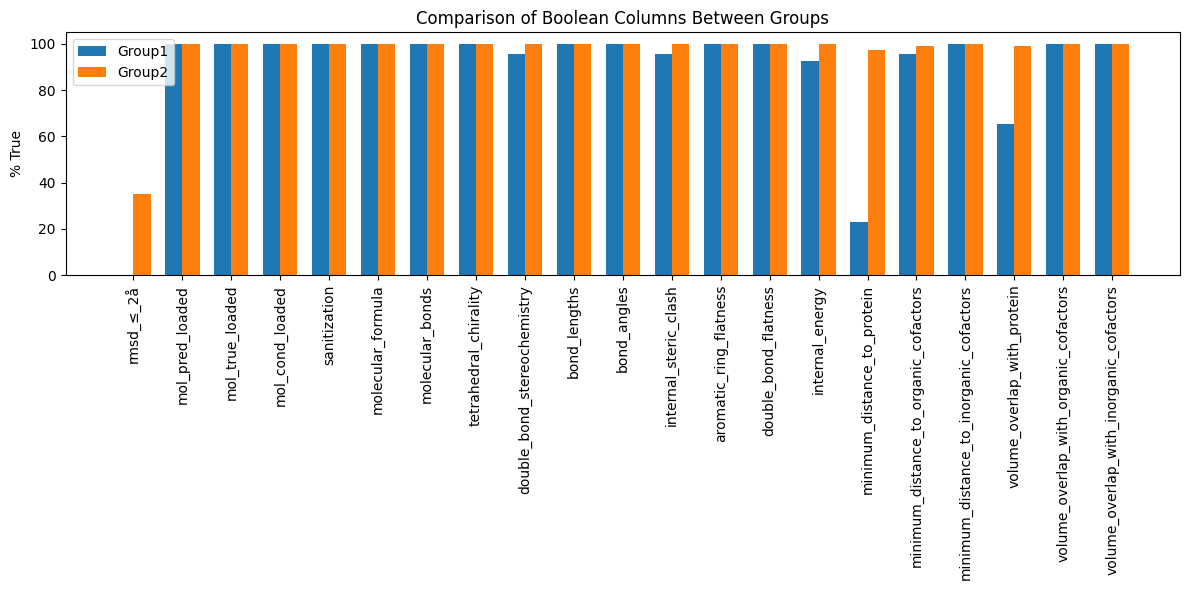

In [36]:
group1_data = df[df['protein'].isin(surfdock_complement_icm) & df['method'].isin(["surfdock"])]
group2_data = df[df['protein'].isin(surfdock_complement_icm) & df['method'].isin(["icm"])]
surfdock_complementicm_stat = compare_boolean_columns(group1_data, group2_data, BUST_TEST_COLUMNS)

Group 1 percentage of True:
rmsd_≤_2å                                    0.0
mol_pred_loaded                            100.0
mol_true_loaded                            100.0
mol_cond_loaded                            100.0
sanitization                               100.0
molecular_formula                          100.0
molecular_bonds                            100.0
tetrahedral_chirality                      100.0
double_bond_stereochemistry                100.0
bond_lengths                               100.0
bond_angles                                100.0
internal_steric_clash                      100.0
aromatic_ring_flatness                     100.0
double_bond_flatness                       100.0
internal_energy                            100.0
minimum_distance_to_protein                 96.0
minimum_distance_to_organic_cofactors      100.0
minimum_distance_to_inorganic_cofactors    100.0
volume_overlap_with_protein                100.0
volume_overlap_with_organic_cofactors    

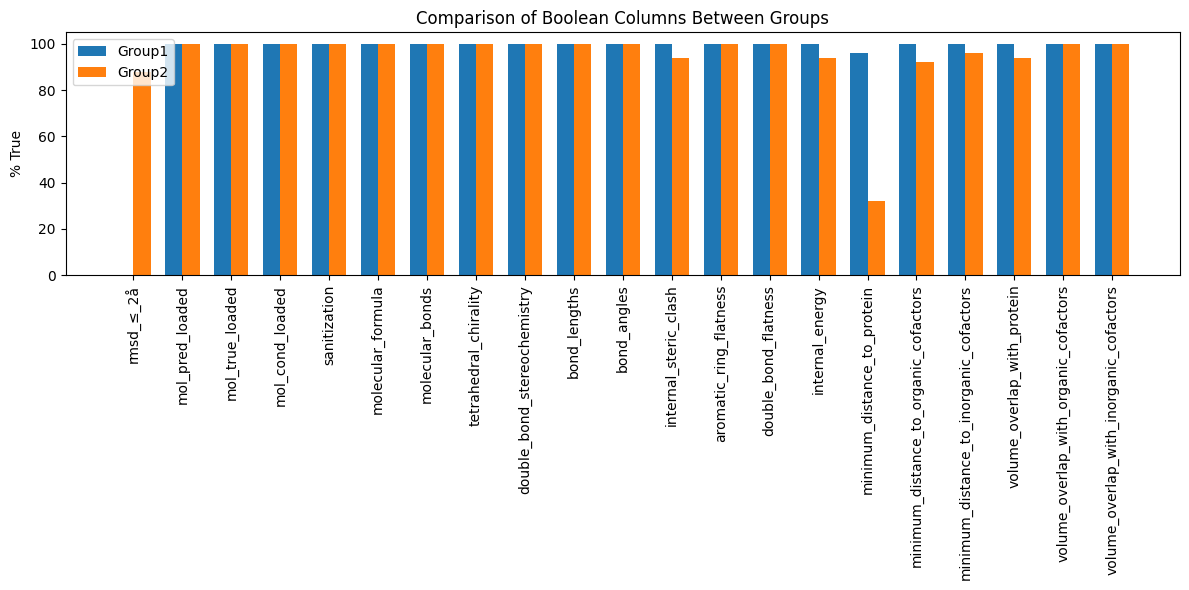

In [26]:
group1_data_icm = df[df['protein'].isin(icm_complement_surfdock) & df['method'].isin(["icm"])]
group1_data_surfdock = df[df['protein'].isin(icm_complement_surfdock) & df['method'].isin(["surfdock"])]
surfdock_complementicm_stat = compare_boolean_columns(group1_data_icm, group1_data_surfdock, BUST_TEST_COLUMNS)

### protein features 

In [37]:
from Approach import DockingApproach, DiffDockApproach, ICMApproach, ChaiApproach, VinaApproach, GninaApproach, SurfDockApproach

def get_predicted_ligand_path(
    df: pd.DataFrame,
    approach: DockingApproach,
    base_outdir: str,
    data_dir: str,
    top_n: int = 5,
) -> pd.DataFrame:
    """
    For each protein subdir in base_outdir:
      - list up to top_n SDF files (method-specific naming)
      - parse a numeric score or confidence if available
      - collect results in a DataFrame with the predicted ligand file path for each entry.
    """
    method_name = approach.get_name()
    all_rows = []

    for protein_name in os.listdir(base_outdir):
        protein_dir = os.path.join(base_outdir, protein_name)
        if not os.path.isdir(protein_dir):
            continue

        # Retrieve up to top-N .sdf file paths
        sdf_paths = approach.list_top_n_files(protein_dir, top_n)
        if not sdf_paths:
            print(f"[{method_name}] No top-{top_n} SDF files found for {protein_name}")
            continue

        # References
        true_ligand = os.path.join(data_dir, protein_name, f"{protein_name}_ligand.sdf")
        protein_pdb = os.path.join(data_dir, protein_name, f"{protein_name}_protein.pdb")
        if not (os.path.isfile(true_ligand) and os.path.isfile(protein_pdb)):
            print(f"[{method_name}] Missing reference for {protein_name}")
            continue

        rank_counter = 1
        for sdf_path in sdf_paths:
            try:
                # parse numeric score or confidence if available
                numeric_score = approach.parse_score(sdf_path)
                
                row = {
                    "predicted_ligand": sdf_path,
                    "score": numeric_score,  # or "confidence_score" or "docking_score"
                    "method": method_name,
                    "protein": protein_name,
                    "rank": rank_counter,
                    "true_ligand": true_ligand,
                    "protein_pdb": protein_pdb,
                }
                rank_counter += 1

                all_rows.append(row)
            except Exception as e:
                print(f"[{method_name}] [ERROR] PoseBusters failed for {protein_name}: {e}")

    if not all_rows:
        return pd.DataFrame()
    return pd.DataFrame(all_rows)

In [41]:
# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"

exp_name = "posebusters_benchmark_outputs_1"

# Initialize your approaches
approaches = [
    ICMApproach(),
    DiffDockApproach(),
    ChaiApproach(),
    VinaApproach(),
    GninaApproach(), 
    SurfDockApproach(),
    # ... add more if needed
]

BASE_DIRS = {
    "icm": f"{base_outdir}/ICM/inference/icm_manual_{exp_name}",
    "diffdock": f"{base_outdir}/Diffdock/inference/diffdock_posebusters_benchmark_output_orig_structure_1",
    "diffdock_pocket_only": f"{base_outdir}/Diffdock/inference/diffdock_pocket_only_posebusters_benchmark_output_orig_structure_0",
    "chai-1": f"{base_outdir}/chai-lab/inference/chai-lab_{exp_name}",
    "vina": f"{base_outdir}/Vina/inference/GT_pocket_vina_posebusters_benchmark_outputs_orig_structure_2",    
    "gnina": f"{base_outdir}/GNINA/inference/GT_pocket_gnina_posebusters_benchmark_outputs_1",
    "surfDock": f"/Users/aoxu/Downloads/SurfDock_docking_result",
}

# The folder containing the real (crystal) ligand and protein PDB:
#  PoseBench/data/posebusters_benchmark_set/<protein>/
DATA_DIR = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"


In [ ]:
df_all = []

for approach in approaches:
    method_name = approach.get_name()
    base_outdir = BASE_DIRS[method_name]
    df_method = get_predicted_ligand_path(
        df,
        approach,
        base_outdir=base_outdir,
        data_dir=DATA_DIR,
        top_n=5
    )
    if not df_method.empty:
        df_all.append(df_method)

if df_all:
    df_combined = pd.concat(df_all, ignore_index=True)
    print(df_combined.shape)
    df_combined.head()
else:
    print("No ligands found for any approaches.")


In [53]:
merged_df = pd.merge(
    df,
    df_combined[["protein", "method", "rank", "predicted_ligand", "true_ligand"]],
    on=["protein", "method", "rank"],
    how="left"
)
print(merged_df.shape)

(9245, 138)


In [ ]:
file_path = "posebusters_results_filtered_with_descriptors_predicted_ligands.csv"
merged_df.to_csv(file_path, index=False)


DataFrame saved to posebusters_results_filtered_with_descriptors_predicted_ligands.csv


In [60]:
import os
from rdkit import Chem
from prolif import Fingerprint, Molecule

def compute_ifp(protein_pdb, gt_ligand_sdf):
    """Compute the interaction fingerprint using the ground-truth ligand."""
    # Load the ground truth ligand
    gt_supplier = Chem.SDMolSupplier(gt_ligand_sdf)
    gt_ligand_rdkit = next((mol for mol in gt_supplier if mol is not None), None)
    if gt_ligand_rdkit is None:
        print(f"Failed loading ligand from {gt_ligand_sdf}")
        return None
    # Convert ligand and protein to ProLIF molecules
    gt_ligand = Molecule.from_rdkit(gt_ligand_rdkit)
    protein_rdkit = Chem.MolFromPDBFile(protein_pdb, removeHs=False)
    if protein_rdkit is None:
        print(f"Failed loading protein from {protein_pdb}")
        return None
    protein_mol = Molecule(protein_rdkit)
    
    # Initialize and compute the fingerprint
    fp = Fingerprint(Fingerprint.list_available())
    fp.run(protein_mol, gt_ligand)
    return fp.generate(protein_mol, gt_ligand)



In [61]:
protein_pdb = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set/7PK0_BYC/7PK0_BYC_protein.pdb"
gt_ligand_sdf = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set/7PK0_BYC/7PK0_BYC_ligand.sdf"
fp = compute_ifp(protein_pdb, gt_ligand_sdf)

TypeError: run() missing 1 required positional argument: 'prot'

In [ ]:
# Choose one of the complementary protein groups, for example unique_proteins_group1
results = {}
for prot in unique_proteins_group1:
    protein_pdb = os.path.join(BASE_DIR, prot, f"{prot}_protein.pdb")
    gt_ligand_sdf = os.path.join("GT_ligands", f"{prot}_ligand.sdf")
    ifp = compute_ifp(protein_pdb, gt_ligand_sdf)
    if ifp is not None:
        results[prot] = ifp

# Print results for each protein
for prot, ifp in results.items():
    print(f"Protein: {prot}")
    print(ifp)